In [38]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import torchmetrics
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision      # 数据库模块
import matplotlib.pyplot as plt
from IPython import display
from d2l import torch as d2l
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [39]:
train_dataset = torchvision.datasets.MNIST(root='./mnist',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./mnist',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

In [40]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [41]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

In [42]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   
        images = Variable(images.view(-1, 28*28))         
        labels = Variable(labels)

        optimizer.zero_grad()                             
        outputs = net(images)                             
        loss = criterion(outputs, labels)                 
        loss.backward()                                   
        optimizer.step()                                 

        if (i+1) % 234 == 0:                              
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))


Epoch [1/10], Step [234/234], Loss: 0.5214
Epoch [2/10], Step [234/234], Loss: 0.4079
Epoch [3/10], Step [234/234], Loss: 0.3459
Epoch [4/10], Step [234/234], Loss: 0.2501
Epoch [5/10], Step [234/234], Loss: 0.3378
Epoch [6/10], Step [234/234], Loss: 0.3115
Epoch [7/10], Step [234/234], Loss: 0.3153
Epoch [8/10], Step [234/234], Loss: 0.2694
Epoch [9/10], Step [234/234], Loss: 0.3458
Epoch [10/10], Step [234/234], Loss: 0.3352


In [43]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count

print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))
#计算准确率
def net_accurary(data_iter,net):
    right_sum,n = 0.0,0
    for X,y in data_iter:
    #从迭代器data_iter中获取X和y
        right_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        #计算准确判断的数量
        n +=y.shape[0]
        #通过shape[0]获取y的零维度（列）的元素数量
    return right_sum/n

Accuracy of the network on the 10K test images: 92 %


In [44]:
torch.save(net, 'soft_max.pkl')

In [45]:
def test_loop(dataloader, model, loss_fn):
    # 实例化相关metrics的计算对象
    test_acc = torchmetrics.Accuracy()
    test_recall = torchmetrics.Recall(average='none', num_classes=10)
    test_precision = torchmetrics.Precision(average='none', num_classes=10)
    test_auc = torchmetrics.AUROC(average="macro", num_classes=10)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X=Variable(X.view(-1, 28 * 28))
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # 一个batch进行计算迭代
            test_acc(pred.argmax(1), y)
            test_auc.update(pred, y)
            test_recall(pred.argmax(1), y)
            test_precision(pred.argmax(1), y)

    test_loss /= num_batches
    correct /= size

    # 计算一个epoch的accuray、recall、precision、AUC
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    total_auc = test_auc.compute()
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, "
          f"Avg loss: {test_loss:>8f}, "
          f"torch metrics acc: {(100 * total_acc):>0.1f}%\n")
    print("recall of every test dataset class: ", total_recall)
    print("precision of every test dataset class: ", total_precision)
    print("auc:", total_auc.item())

    # 清空计算对象
    test_precision.reset()
    test_acc.reset()
    test_recall.reset()
    test_auc.reset()

net1=torch.load("soft_max.pkl")
loss=nn.CrossEntropyLoss()
test_loop(test_loader,net1,loss)

E:\ProgramData\Miniconda3\envs\d2l\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Test Error: 
 Accuracy: 92.4%, Avg loss: 0.268028, torch metrics acc: 92.4%

recall of every test dataset class:  tensor([0.9796, 0.9833, 0.8944, 0.9198, 0.9236, 0.8531, 0.9489, 0.9144, 0.8943,
        0.9177])
precision of every test dataset class:  tensor([0.9505, 0.9662, 0.9304, 0.9002, 0.9331, 0.9213, 0.9410, 0.9344, 0.8701,
        0.8904])
auc: 0.9808036684989929


In [46]:
pre_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)
test_data = iter(pre_loader)
category_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
test_label = []
test_pred = []
for data in test_data:
    images, labels = data
    images = Variable(images.view(-1, 28 * 28))
    outputs = net1(images)
    _, predicted = torch.max(outputs.data, 1)
    test_label.append(category_dict[labels.item()])
    test_pred.append(category_dict[predicted.item()])


In [47]:
cm = confusion_matrix(test_label, test_pred)
cm

array([[ 960,    0,    2,    1,    0,    5,    6,    3,    3,    0],
       [   0, 1116,    2,    2,    0,    2,    4,    2,    7,    0],
       [   7,   10,  923,   17,    8,    2,   11,    9,   40,    5],
       [   3,    0,   18,  929,    0,   18,    1,   11,   21,    9],
       [   1,    1,    4,    1,  907,    0,   12,    2,   10,   44],
       [   8,    2,    4,   41,   10,  761,   14,    7,   37,    8],
       [  12,    3,    8,    1,    8,   12,  909,    2,    3,    0],
       [   1,    8,   23,    7,    6,    0,    0,  940,    3,   40],
       [   7,    9,    6,   23,    9,   21,    9,   11,  871,    8],
       [  11,    6,    2,   10,   24,    5,    0,   19,    6,  926]],
      dtype=int64)

<AxesSubplot:>

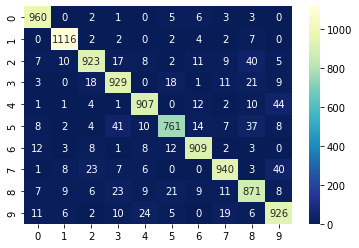

In [52]:
sns.heatmap(cm,cmap="YlGnBu_r",annot=True,fmt="d")